# Wind Farm Generation Analysis

This notebook demonstrates how to calculate potential wind power generation using ERA5 climate data. We'll use wind speed data at 100m height to estimate power output for a hypothetical wind farm

## Overview of the Process

- Connect to IPFS nodes to access climate data

- Install required packages

- Load ERA5 wind data (u and v components)

- Extract data for our wind farm location

- Apply a wind turbine power curve to calculate generation

- Visualize and analyze the results

## 1. IPFS Connection

First, we connect to IPFS (InterPlanetary File System) nodes that host our climate data. This distributed storage system allows efficient access to large climate datasets.

In [1]:
!ipfs version

ipfs version 0.33.1


In [2]:
# Fluorine Node
!ipfs swarm peering add "/ip4/15.235.14.184/udp/4001/quic-v1/p2p/12D3KooWHdZM98wcuyGorE184exFrPEJWv2btXWWSHLQaqwZXuPe"

# Cerium Node
!ipfs swarm peering add "/ip4/15.235.86.198/udp/4001/quic-v1/p2p/12D3KooWGX5HDDjbdiJL2QYf2f7Kjp1Bj6QAXR5vFvLQniTKwoBR"

# Bismuth Node
!ipfs swarm peering add "/ip4/40.160.21.102/udp/4001/quic-v1/p2p/12D3KooWEaVCpKd2MgZeLugvwCWRSQAMYWdu6wNG6SySQsgox8k5"

add 12D3KooWHdZM98wcuyGorE184exFrPEJWv2btXWWSHLQaqwZXuPe success
add 12D3KooWGX5HDDjbdiJL2QYf2f7Kjp1Bj6QAXR5vFvLQniTKwoBR success
add 12D3KooWEaVCpKd2MgZeLugvwCWRSQAMYWdu6wNG6SySQsgox8k5 success


## 2. Package Installation

We'll install the necessary Python packages for data analysis and visualization:

In [3]:
!uv pip install xarray==2024.11.0 zarr==2.18.4 multiformats git+https://github.com/dClimate/py-hamt.git@4a848b50ff3325463b12f11119dfdd5d151668a0 geopandas fiona geopy simplekml matplotlib

Using Python 3.12.7 environment at: /opt/venv
Resolved 54 packages in 5.49s                                        
Prepared 43 packages in 47.37s                                           
░░░░░░░░░░░░░░░░░░░░ [0/43] Installing wheels...                                warning: Failed to hardlink files; falling back to full copy. This may lead to degraded performance.
         If the cache and target directories are on different filesystems, hardlinking may not be supported.
         If this is intentional, set `export UV_LINK_MODE=copy` or use `--link-mode=copy` to suppress this warning.
Installed 43 packages in 324ms                              
 + asciitree==0.3.3
 + bases==0.3.0
 + blake3==1.0.4
 + click==8.1.8
 + click-plugins==1.1.1
 + cligj==0.7.2
 + contourpy==1.3.1
 + cycler==0.12.1
 + dag-cbor==0.3.3
 + deprecated==1.2.18
 + fasteners==0.19
 + fiona==1.10.1
 + fonttools==4.56.0
 + geographiclib==2.0
 + geopandas==1.0.1
 + geopy==2.4.1
 + kiwisolver==1.4.8
 + markdown-it-py==

## 3. Data Loading and Preparation

Now we'll load the ERA5 wind data components. ERA5 is a climate reanalysis dataset produced by the European Centre for Medium-Range Weather Forecasts (ECMWF).

### Understanding Wind Components

- **u-component**: East-west wind component (positive = westerly wind)
- **v-component**: North-south wind component (positive = southerly wind)

We'll combine these components to calculate wind speed magnitude.

In [ ]:
import time
import xarray as xr
from py_hamt import HAMT, IPFSStore
from multiformats import CID
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
from geopy import geocoders 
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import simplekml
from shapely.geometry import Point, Polygon, MultiPolygon, shape
import matplotlib.pyplot as plt

print("Imported all packages")

# Start timing
start_time = time.perf_counter()

# Load Wind Power Curve CSV (This CSV has a generic power curve we created that is percent of max capacity by wind speed in m/s)
fname='Windfarms_ALL_new_percent_of_max_power_curve.csv' # Wind Turbine Power Curve Filename
power_curve_all_df=pd.read_csv(fname) # Load csv into a pandas dataframe
del fname

# Root CID of the HAMT
era5_100m_uwind_cid = "bafyr4ic3bnbcemyxllvdwrz2jxeccxlyjqxllz3csqjwsf4ihapj4kundy"
era5_100m_vwind_cid = "bafyr4ianhuujwxgivs7m3xk7t4k7xi4bqkivb4asjid26fa3bv4ssy5jqm"

era5_100m_uwind_root_cid = CID.decode(era5_100m_uwind_cid)
era5_100m_vwind_root_cid = CID.decode(era5_100m_vwind_cid)

# Create HAMT instance using the IPFSStore
era5_100m_uwind_hamt = HAMT(store=IPFSStore(gateway_uri_stem="http://0.0.0.0:8080", timeout_seconds=1000), root_node_id=era5_100m_uwind_root_cid, )
era5_100m_vwind_hamt = HAMT(store=IPFSStore(gateway_uri_stem="http://0.0.0.0:8080", timeout_seconds=1000), root_node_id=era5_100m_vwind_root_cid)

era5_100m_uwind = xr.open_zarr(store=era5_100m_uwind_hamt)
print("Loaded era5_100m_uwind")

era5_100m_vwind = xr.open_zarr(store=era5_100m_vwind_hamt)
print("Loaded era5_100m_vwind")

## 4. Wind Farm Location Selection

We'll define our wind farm location and extract the relevant data for that geographic area. We need to:

1. Define the wind farm coordinates
2. Find the closest ERA5 grid point to our location
3. Extract data for a small region around this point

In [ ]:
########################################################################################################################################
# THIS SECTION IS WHERE USER ENTERS THE INFO FOR THEIR SIMULATION

# Enter Wind Farm Info
wind_farm_lat=30.30087157112338 # Latitude of Wind Farm 
wind_farm_lon=-97.8192644357404 # Longitude of Wind Farm (I am using -180,180 format here)
wind_farm_max_capacity_mw=100 # Maximum Capacity of Wind Farm In MW

# Define time range
start_date = "2024-03-01" # Date to Start Analysis
end_date = "2024-03-07" # Date to End Analysis

########################################################################################################################################

################ Get all pairs of lat,lon in ERA5 100m dataset #####################
def df_of_all_lat_lons_funct(ds):
    # This function takes in a xarray dataset of weather and returns all lat/lon pairs in a pandas dataframe
    # Assumption is long in ds is 0,360 format (ERA5)
    
    # ds is your xarray dataset of weather variable
    latitudes = ds.latitude.values
    longitudes = ds.longitude.values
    
    # Create a 2D mesh of lat/lon pairs
    lat_grid, lon_grid = np.meshgrid(latitudes, longitudes, indexing='ij')
    
    # Flatten the arrays to get coordinate pairs
    lat_flat = lat_grid.ravel()
    lon_flat_360 = lon_grid.ravel()
    
    # Convert longitude from 0-360 to -180 to 180
    lon_flat_180 = np.where(lon_flat_360 > 180, lon_flat_360 - 360, lon_flat_360)
    
    # Create a DataFrame
    df = pd.DataFrame({
        "lat": lat_flat,
        "lon_360": lon_flat_360,
        "lon_180": lon_flat_180,
        "geometry": [Point(lon, lat) for lon, lat in zip(lon_flat_180, lat_flat)]
    })

    return df

all_lat_lon_pairs=df_of_all_lat_lons_funct(era5_100m_uwind)
print("all lat lon pairs", all_lat_lon_pairs)

# Calculate distance from each ERA5 point to the wind farm
def haversine(lat1, lon1, df):
    """
    Compute the distance in km between a given point (lat1, lon1)
    and all lat/lon points in a DataFrame.

    Parameters:
    lat1, lon1: float - Reference latitude and longitude
    df: pandas DataFrame - Must contain 'lat' and 'lon_180' columns

    Returns:
    pandas Series with distances in km
    """
    R = 6371  # Earth radius in km

    # Convert degrees to radians
    lat1, lon1 = np.radians(lat1), np.radians(lon1)
    lat2, lon2 = np.radians(df["lat"]), np.radians(df["lon_180"])

    # Compute differences
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # Distance in km

all_lat_lon_pairs['distance']=haversine(wind_farm_lat, wind_farm_lon, all_lat_lon_pairs) # Get Distance of Wind Farm to each ERA5 lat,lon (in km)
closest_era5_lat_lon_point=all_lat_lon_pairs[all_lat_lon_pairs['distance']==all_lat_lon_pairs['distance'].min()].reset_index(drop=True) # Find Closest lat,lon point 

# Convert From -180,180 to 0,360 for ERA5
def convert_longitude(lon):
    """
    This function converts longitude from -180,180 to 0,360
    """
    return lon % 360 if lon >= 0 else (lon + 360) % 360

# Convert wind_farm_lon to 0,360 longitude format
wind_farm_lon=convert_longitude(wind_farm_lon)


# Define geographic bounding box (Part of Central Texas) Need to clean this up 
lat_min, lat_max = wind_farm_lat-0.25, wind_farm_lat+0.25  # Latitude range (Getting all data within 0.25 either side)
lon_min, lon_max = wind_farm_lon-0.25,wind_farm_lon+0.25  # Longitude range (Getting all data within 0.25 either side)
lon_min, lon_max = convert_longitude(lon_min), convert_longitude(lon_max) # Convert lon to 0,360

## 5. Data Processing

Now we'll process the wind data to prepare it for power generation calculations:

1. Subset the data to our region of interest
2. Convert the xarray datasets to pandas DataFrames for easier manipulation
3. Calculate wind speed magnitude from u and v components

In [ ]:
########### Subset the data ###########
subset_start = time.perf_counter()

# Get Subset of 100m u_wind vector
subset_era5_100m_uwind = era5_100m_uwind.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
    time=slice(start_date, end_date)
)
print("Sliced era5_100m_uwind")

# Get Subset of 100m v_wind vector
subset_era5_100m_vwind = era5_100m_vwind.sel(
    latitude=slice(lat_max, lat_min),
    longitude=slice(lon_min, lon_max),
    time=slice(start_date, end_date)
)
print("Sliced era5_100m_vwind")

subset_end = time.perf_counter()
print(f"Subsetting data took {subset_end - subset_start:.2f} seconds")

########### Convert Slices to DataFrames ###########
convert_start = time.perf_counter()

print("1")
# Convert the xarray dataset subset_era5_100m_uwind to a pandas DataFrame and reset the index
df_u100 = subset_era5_100m_uwind['100m_u_component_of_wind'].to_dataframe().reset_index()

print("2")
# Convert the xarray dataset subset_era5_100m_vwind to a pandas DataFrame and reset the index
df_v100 = subset_era5_100m_vwind['100m_v_component_of_wind'].to_dataframe().reset_index()

print("3")
# Reshape the DataFrame so that each unique (latitude, longitude) pair gets its own column
# The index is set to 'time', and the values are taken from the '100m_u_component_of_wind' column
df_u100 = df_u100.pivot(index='time', columns=['latitude', 'longitude'], values='100m_u_component_of_wind')

print("4")
# Perform the same pivot operation for the v-component of wind
df_v100 = df_v100.pivot(index='time', columns=['latitude', 'longitude'], values='100m_v_component_of_wind')

print("5")
# Rename the columns to a more readable format, using (latitude, longitude) tuples as column names
df_u100.columns = [f"({lat}, {lon})" for lat, lon in df_u100.columns]
df_v100.columns = [f"({lat}, {lon})" for lat, lon in df_v100.columns]


print("6")
convert_end = time.perf_counter()
print(f"DataFrame conversion took {convert_end - convert_start:.2f} seconds")

# End timing
end_time = time.perf_counter()
print(f"Total execution time: {end_time - start_time:.2f} seconds")

# Calculate 100m wind speed from u and v vectors
df_100_wind=((df_u100**2)+(df_v100**2))**(1/2)

# Get wind speed for lat/lon closest to wind farm
era5_lat_lon_ref_string='('+str(float(closest_era5_lat_lon_point['lat'][0]))+', '+str(float(closest_era5_lat_lon_point['lon_360'][0]))+')' # String for ERA5 point (EX: '(30.25, 262.25)')
U_wind=pd.DataFrame(df_100_wind[era5_lat_lon_ref_string]) # Make a dataframe called U_wind that is a single column of 100m winds at the lat/lon closest to the wind farm
U_wind.columns=['U_wind'] # Rename the column in U_wind df "U_wind"

## 6. Wind Turbine Power Curve Application

A power curve shows the relationship between wind speed and power output for a specific wind turbine model. We'll use this to convert our wind speed data into power generation estimates.

### How Power Curves Work

- Below cut-in speed: No power generation
- Between cut-in and rated speed: Power increases (often following a cubic relationship)
- At rated speed: Turbine reaches maximum power output
- Above cut-out speed: Turbine shuts down for safety

In [ ]:
############### Create Power Curve Formatted to Obtain Percent of Max ###############
pctuse=power_curve_all_df.drop(['Man. ID','Manufucturer Name','Turb. ID','Turbine Name'],axis=1)
power_curve_hub_height_wind_speed=pd.DataFrame(pctuse.columns)
power_curve_hub_height_wind_speed.columns=['Hub_Height_Wind_Speed']
power_curve_pct_max=pd.DataFrame(pctuse.iloc[0,:])
power_curve_pct_max=power_curve_pct_max.reset_index(drop=True)
power_curve_pct_max.columns=['Percent_of_Max_Power']

reformatted_pctuse=pd.concat([power_curve_hub_height_wind_speed.astype(float),power_curve_pct_max],axis=1)

del pctuse,power_curve_hub_height_wind_speed,power_curve_pct_max

## 7. Wind Power Generation Calculation

Now we'll calculate the actual power output by:

1. Finding the closest power curve wind speed to our ERA5 wind speed at each time step
2. Getting the corresponding percentage of maximum power
3. Multiplying by the wind farm's maximum capacity to get actual generation in MWh

Imported all packages
Loaded era5_100m_uwind
Loaded era5_100m_vwind
all lat lon pairs           lat  lon_360  lon_180           geometry
0        90.0     0.00     0.00       POINT (0 90)
1        90.0     0.25     0.25    POINT (0.25 90)
2        90.0     0.50     0.50     POINT (0.5 90)
3        90.0     0.75     0.75    POINT (0.75 90)
4        90.0     1.00     1.00       POINT (1 90)
...       ...      ...      ...                ...
1038235 -90.0   358.75    -1.25  POINT (-1.25 -90)
1038236 -90.0   359.00    -1.00     POINT (-1 -90)
1038237 -90.0   359.25    -0.75  POINT (-0.75 -90)
1038238 -90.0   359.50    -0.50   POINT (-0.5 -90)
1038239 -90.0   359.75    -0.25  POINT (-0.25 -90)

[1038240 rows x 4 columns]
Sliced era5_100m_uwind
Sliced era5_100m_vwind
Subsetting data took 0.05 seconds
1
2
3
4
5
6
DataFrame conversion took 798.35 seconds
Total execution time: 824.95 seconds


<Figure size 1200x600 with 0 Axes>

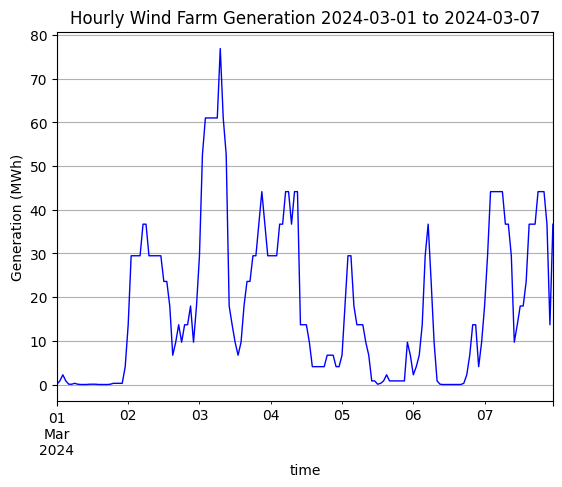

Done


In [5]:
############### Obtain the power output (multiply the percent of max power by the total power for each timestep) ###############
xx, yy = np.meshgrid(U_wind.U_wind,reformatted_pctuse.Hub_Height_Wind_Speed) # Create a meshgrid from the wind speed data: U_wind.U_wind is observed ERA5 wind speeds, reformatted_pctuse.Hub_Height_Wind_Speed represents percent of max generation for hub height wind speeds 
zz=abs(yy-xx) # Compute the absolute difference between the two grids
del xx,yy # Delete temporary variables to free up memory 

zz=pd.DataFrame(zz).idxmin() # Find the index of the minimum difference for each column. This identifies the closest Percent of Capacity Wind Speed to the ERA5 observed wind speed
raw_energy_output=reformatted_pctuse['Percent_of_Max_Power'].get(key=zz) # Extract the corresponding power generation percentage from the lookup table
raw_energy_output=raw_energy_output.reset_index(drop=True) # Reset index to flatten the resulting series
raw_energy_output=raw_energy_output*wind_farm_max_capacity_mw # Scale by the wind farm's maximum capacity to get actual power generation (MWh)
raw_energy_output=pd.concat([pd.DataFrame(U_wind.index),raw_energy_output],axis=1) # Combine with the original U_wind index (timestamps) 
raw_energy_output=raw_energy_output.set_index('time') # Set the index to the time column for time series analysis 
raw_energy_output.columns=['Wind_Farm_Generation_MWh'] # Rename the output column to indicate wind farm generation in MWh  

## 8. Time Series Aggregation

We'll aggregate our hourly generation data to different time scales to analyze patterns:

- Daily
- Monthly
- Yearly



In [ ]:
# Resample generation data from hourly to different time scales (MW/h aggregation):
daily_raw_energy_output=raw_energy_output.resample('d').sum() # Daily
monthly_raw_energy_output=raw_energy_output.resample('ME').sum() # Monthly
yearly_raw_energy_output=raw_energy_output.resample('YE').sum() # Yearly

## 9. Visualization and Analysis

Finally, we'll visualize our results to understand the wind farm's generation patterns:"

In [ ]:
###### Plot Hourly Wind Farm Generation
# Plot the time series
plt.figure(figsize=(12, 6))
raw_energy_output.plot(y="Wind_Farm_Generation_MWh", legend=False, color="blue", linewidth=1)

# Formatting
plt.title("Hourly Wind Farm Generation "+start_date+" to "+end_date)
plt.ylabel("Generation (MWh)")
plt.grid(True)
plt.show()
plt.close()

## 10. Conclusion and Next Steps

We've successfully estimated wind power generation using ERA5 climate data. Some potential next steps:

1. Compare results with actual wind farm data for validation
2. Analyze seasonal and diurnal patterns in generation
3. Explore how generation might change under future climate scenarios
4. Optimize turbine selection based on the wind resource at this location
5. Perform economic analysis (capacity factor, revenue potential, etc.)

Extra credit: The CSV file is the power curve file (we normally interpolate the curve to get higher resolution but we left that off)